In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import dhalo

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

%matplotlib inline

/cosma/local/Python/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Analysis parameters

In [2]:
grav = "GR"
# prof = "nfw"
snap = 75
# NFW_f = 0.02
nbins = 20
bin = 10

r = dhalo.DHaloReader("./data/cache.pkl")
d = r.data.loc[np.genfromtxt("./out/ids.%03d.%s.txt" % (snap, grav))].dropna()

In [3]:
counts, bin_edges = np.histogram(np.log10(d["particleNumber"]), nbins)
d["bin"] = np.digitize(np.log10(d["particleNumber"]), bin_edges)

### Collapsed Mass History

In [4]:
ms = np.array(
    pd.read_csv("./out/cmh.%03d.f002.%s.csv" % (snap, grav))
    .set_index("nodeIndex")
    .fillna(0.0)
    .loc[d[d["bin"] == bin].index],
    dtype = float)

In [5]:
zs = np.genfromtxt(
    "./out/trees/GR/redshift_list.txt",
    dtype=np.dtype(
        [("snap", np.int), ("z", np.float)]
    )
)

def z2rho_c(z):
    h = 0.697
    Rho0 = 147.7543  # rho_crit(z = 0) in M_solar/kpc^3
    OmegaM = 0.281
    OmegaL = 1. - OmegaM
    return Rho0 * (OmegaM * np.power(1.0 + z, 3.) + OmegaL)

rho_c = np.divide(
    z2rho_c(zs["z"]),
    z2rho_c(zs[zs["snap"] == snap][0]["z"])
)[8:]

In [6]:
def halo_mass_history(ms):
    ms = np.divide(ms.T, ms[:,-1]).T
    m = np.median(ms, axis=0)

    return ms, m

/cosma/local/Python/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/cosma/local/Python/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


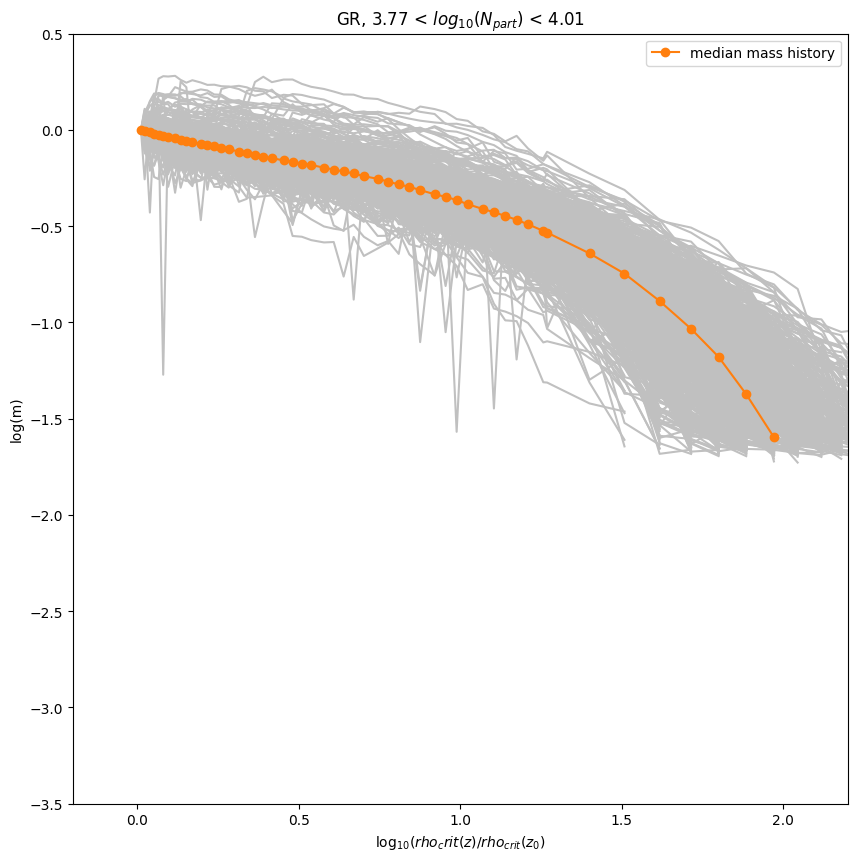

In [7]:
def plot_halo_mass_history(ax, *args):
    ms, m = args
    [ax.plot(np.log10(rho_c[:-1]), np.log10(_), color='silver') for _ in ms]
    ax.plot(np.log10(rho_c[:-1]), np.log10(m), color='C1', marker='o', label='median mass history')
    ax.legend()

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title("%s, %.2f < $log_{10}(N_{part})$ < %.2f" %
             (grav, bin_edges[bin], bin_edges[bin+1]))
ax.set_xlabel(r"$\log_{10}(rho_crit(z) / rho_{crit}(z_0)$")
ax.set_xlim((-0.2, 2.2))
ax.set_ylim((-3.5, 0.5))
ax.set_ylabel("log(m)")
plot_halo_mass_history(ax, *halo_mass_history(ms))

# fig.savefig("./fig.pdf")